In [2]:
import scanpy as sc
import re
import numpy as np  


In [2]:
raw_data = sc.read_h5ad("../Geneformer_model/data/raw_counts_adata.h5ad")
raw_data.var

/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,gene_name
0,AP006222.2
1,FAM87B
2,LINC00115
3,FAM41C
4,SAMD11
...,...
15364,MT-ND4L
15365,MT-ND4
15366,MT-ND5
15367,MT-ND6


### Note: loaded raw data has been filtered
- for cell: doublet and dying cells
- for gene: filtered for overlapping genes

In [3]:
raw_data

AnnData object with n_obs × n_vars = 25066 × 15369
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name'

### Remove clono, sex and mitochondrial genes

In [31]:
def get_clono_features(features):
    patterns = ["TRAV", "TRAJ", "TRBV", "TRBJ", "TRDV", "TRDJ", "TRGV", "TRGJ", 
                "IGKV", "IGKJ", "IGLV", "IGLJ", "IGHV", "IGHJ", "AC0", "SP00", 
                "AP00", "AC15", "MT-"]
    special_features = {"XIST", "RPS4Y1", "RPS4Y2"}

    clono_features = set()

    for pattern in patterns:
        clono_features.update([i for i, feature in enumerate(features) if pattern in feature])

    clono_features.update([i for i, feature in enumerate(features) if feature in special_features])

    return list(clono_features)

clono_feature_indices = get_clono_features(adata.var.gene_name)
mask = np.zeros(adata.shape[1], dtype=bool)
mask[clono_feature_indices] = True

adata = adata[:, ~mask]
adata


View of AnnData object with n_obs × n_vars = 25066 × 15093
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [32]:
adata.write_h5ad("clono_filtered_counts_adata.h5ad")

In [33]:
adata = sc.read_h5ad("clono_filtered_counts_adata.h5ad")

In [34]:
adata.var

,gene_name,highly_variable,highly_variable_rank,means,variances,variances_norm
1,FAM87B,True,4106.0,0.000040,0.000040,1.000080
2,LINC00115,False,NaN,0.014841,0.015658,0.859693
3,FAM41C,False,NaN,0.000439,0.000439,0.929125
4,SAMD11,False,NaN,0.000239,0.000239,0.953518
5,NOC2L,True,2040.0,0.531038,1.174560,1.145456
...,...,...,...,...,...,...
15350,FAM224B,False,NaN,0.001715,0.001792,0.901687
15351,TTTY14,False,NaN,0.004548,0.005166,0.944615
15352,KDM5D,False,NaN,0.076358,0.090718,0.967450
15353,TTTY10,False,NaN,0.005944,0.006149,0.855248


In [35]:
num_zero_expression_per_cell = (adata.X == 0).sum(axis=1)
print(num_zero_expression_per_cell)

/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


[[14671]
 [11322]
 [14417]
 ...
 [13185]
 [14060]
 [13531]]


### Examining and selecting highly variable gene for downstream analysis

In [36]:
adata2 = adata.copy()


In [37]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor="seurat_v3")

In [38]:
var_genes_all = adata.var.highly_variable
sum(var_genes_all)

5000

In [39]:
adata2.layers["counts"] = adata2.X.copy()   

In [40]:
# Normalize the data for running highly_variable_genes
sc.pp.normalize_total(adata2)
# Logarithmize the data
sc.pp.log1p(adata2)

In [14]:
adata2.X.min(), adata2.X.max()  

(0.0, 7.167059)

In [26]:
adata2.var

,gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
1,FAM87B,False,0.000118,0.268151,0.033345,0,False
2,LINC00115,True,0.017306,0.978636,0.992867,4,True
3,FAM41C,False,0.000918,-0.159240,-1.148022,0,False
4,SAMD11,False,0.000103,-0.325135,-1.238809,0,False
5,NOC2L,False,0.280633,0.585598,-0.121050,0,False
...,...,...,...,...,...,...,...
15364,MT-ND4L,True,2.956117,1.854945,0.510867,2,False
15365,MT-ND4,False,2.387147,1.476175,0.207451,2,False
15366,MT-ND5,True,2.299105,1.530457,0.588237,3,False
15367,MT-ND6,True,1.110331,1.362928,1.596756,4,True


Tuning min_mean, min_disp to include more genes in the highly variable gene search

In [41]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0010, max_mean=4, min_disp=0.3, batch_key="sample_source")
print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

Highly variable genes intersection: 1184
Number of batches where gene is variable:
highly_variable_nbatches
0    5334
1    3640
2    2874
3    2061
4    1184
Name: count, dtype: int64


In [32]:
# sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key="sample_source")

# print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

# print("Number of batches where gene is variable:")
# print(adata2.var.highly_variable_nbatches.value_counts())

# var_genes_batch = adata2.var.highly_variable_nbatches > 0

Highly variable genes intersection: 344
Number of batches where gene is variable:
highly_variable_nbatches
0    9641
1    3020
2    1591
3     773
4     344
Name: count, dtype: int64


In [42]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 9759
All data var genes: 5000
Overlap: 3113
Variable genes in all batches: 2061
Overlap batch instersection and all: 420


Select all genes that are variable in at least 1 datasets

In [46]:
var_select = adata2.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)

6119

In [47]:
# split per batch into new objects.
batches = adata.obs['sample_source'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample_source'] == batch,]

alldata   

{'Good': View of AnnData object with n_obs × n_vars = 6203 × 15093
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     layers: 'counts',
 'Deng': View of AnnData object with n_obs × n_vars = 11353 × 15093
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     layers: 'counts',
 'Harad': View of AnnData object with n_obs × n_vars = 6570 × 15093
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mit

In [50]:
adata2.X.min(), adata2.X.max()

(0.0, 7.202501)

In [49]:
adata.layers["counts"] = adata.X.copy()

In [54]:
import scanorama

#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# Integration and batch correction.
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Good
Deng
Harad
Sheih
Found 6119 genes among all datasets
[[0.         0.49524424 0.41673384 0.1712766 ]
 [0.         0.         0.59984145 0.32234043]
 [0.         0.         0.         0.61595745]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 3)
Processing datasets (0, 3)


In [55]:
corrected


[AnnData object with n_obs × n_vars = 6203 × 6119
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     obsm: 'X_scanorama',
 AnnData object with n_obs × n_vars = 11353 × 6119
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     obsm: 'X_scanorama',
 AnnData object with n_obs × n_vars = 6570 × 6119
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: '

In [59]:
corrected[0].obsm["X_scanorama"].shape  

(6203, 100)

In [56]:
# get all the integrated matrices
scanorama_integrated = [ad.obsm["X_scanorama"] for ad in corrected]

all_scanorama_integrated = np.concatenate(scanorama_integrated)
print(all_scanorama_integrated.shape)

adata_sc = adata.copy()
adata_sc.obsm["X_scanorama"] = all_scanorama_integrated

(25066, 100)


In [63]:
# Merge the list of AnnData objects into one
import anndata as ad
adata_merged = ad.concat(corrected, axis=0, merge="same")
adata_merged.var

,gene_name,highly_variable,highly_variable_rank,means,variances,variances_norm,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
10,ISG15,True,NaN,0.597397,3.147616,0.922166,0.719496,0.381083,3,False
1000,ZBTB7B,True,NaN,0.100476,0.164609,0.923626,0.755205,0.450267,3,False
10003,FRMD6,False,NaN,0.009258,0.011057,0.846331,0.689102,0.175290,2,False
10007,PTGDR,True,634.0,0.030884,0.054006,1.631302,1.147481,1.147044,4,True
10008,PTGER2,True,NaN,0.515226,1.493604,0.935654,0.875227,0.873475,3,False
...,...,...,...,...,...,...,...,...,...,...
9995,MAP4K5,True,NaN,0.159703,0.222903,0.926564,0.849148,0.637845,4,True
9996,ATL1,False,NaN,0.010354,0.011936,0.920614,0.640592,0.177918,2,False
9997,SAV1,False,NaN,0.025710,0.051958,0.955490,0.516623,0.223656,2,False
9998,NIN,True,4317.0,0.269892,0.469294,0.993432,0.880114,0.782434,4,True


In [64]:
adata_merged

AnnData object with n_obs × n_vars = 25066 × 6119
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_scanorama'

In [58]:
# visualize the integrated data

# tsne and umap
sc.pp.neighbors(adata_sc, n_pcs =30, use_rep = "X_scanorama")
sc.tl.umap(adata_sc)
sc.tl.tsne(adata_sc, n_pcs = 30, use_rep = "X_scanorama")

/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

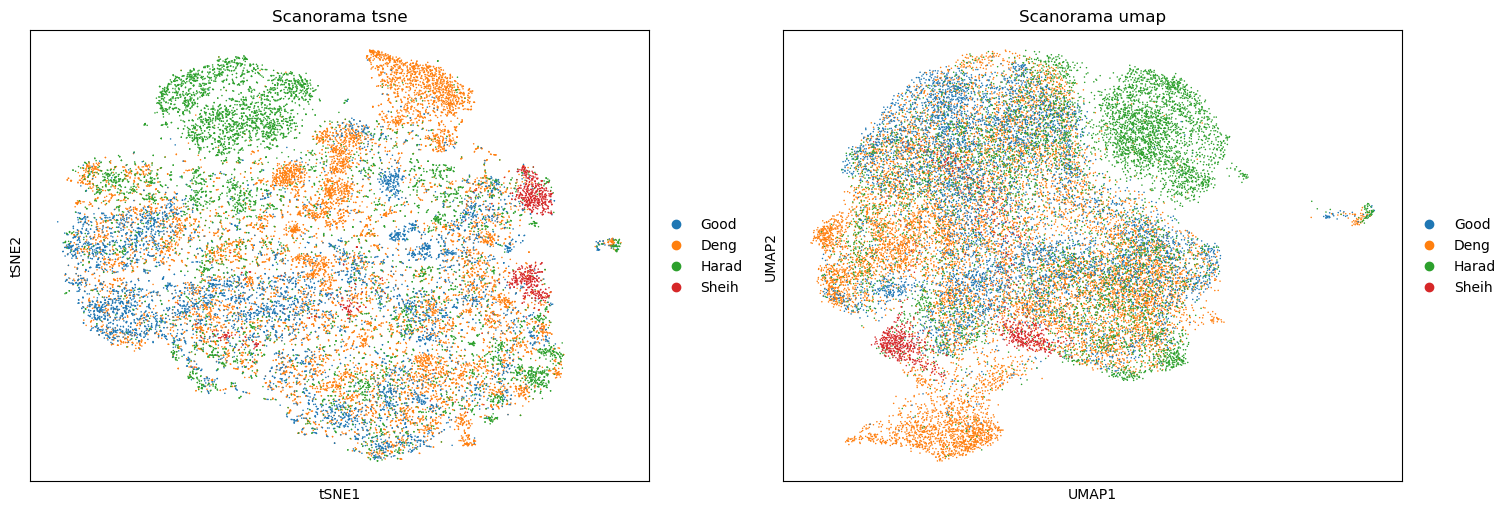

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)

sc.pl.tsne(adata_sc, color="sample_source", title="Scanorama tsne", ax=axs[0], show=False)

sc.pl.umap(adata_sc, color="sample_source", title="Scanorama umap", ax=axs[1], show=False)


In [78]:
# save the scanorama integrated data
adata_merged.write_h5ad("scanorama_integrated_adata.h5ad")

In [1]:
import scanpy
adata_merged = scanpy.read_h5ad("scanorama_integrated_adata.h5ad")

In [3]:
adata_merged.X.min(), adata_merged.X.max()


(-0.07980450947096149, 0.25647117916440004)

In [4]:
adata_merged



AnnData object with n_obs × n_vars = 25066 × 6119
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_scanorama'

In [5]:
# save the cell and gene metadata and write into csv files
adata_merged.obs.to_csv("scanorama_integrated_cell_metadata.csv")
adata_merged.var.to_csv("scanorama_integrated_gene_metadata.csv")